In [1]:
# Character-Level CNN-LSTM model from https://doi.org/10.3390/app131911104

In [2]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import re
from html import unescape
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [3]:
# Data cleaning from https://doi.org/10.3390/app131911104
def preprocess_text(text):
    
    # Step 1: Decoding HTML
    decoded_text = unescape(text)
    
    # Step 2: Removal of emoticons
    decoded_text = re.sub(r'[\U00010000-\U0010ffff]', '', decoded_text)
    
    # Step 3: Removal of mentions (usernames)
    decoded_text = re.sub(r'@\w+', '', decoded_text)
    
    # Step 4: Removal of URL links
    decoded_text = re.sub(r'https?://\S+|www\.\S+', '', decoded_text)
    
    # Step 5: Conversion to lower case
    decoded_text = decoded_text.lower()
    
    # Step 6: Expansion of negations
    decoded_text = re.sub(r"can't", 'cannot', decoded_text)
    # Add more negations as needed
    
    # Step 7: Removal of hashtags, punctuation marks, numbers, and special characters
    decoded_text = re.sub(r'#[\w_]+', '', decoded_text)
    decoded_text = re.sub(r'[^a-zA-Z\s]', '', decoded_text)
    
    # Step 8: Removal of extra white spaces
    decoded_text = re.sub(r'\s+', ' ', decoded_text).strip()
    
    return decoded_text
    

In [4]:
def text_to_one_hot(text):
    
    # English character set
    alphabet = "abcdefghijklmnopqrstuvwxyz "
    unknown_char = "UNK"

    # Create character-to-index mapping
    char_to_index = {char: i for i, char in enumerate(alphabet, start=1)}  # Start index from 1
    char_to_index[unknown_char] = 0  # Index 0 for unknown characters

    # Preprocess input text
    preprocessed_text = preprocess_text(text)

    # Tokenize the text into character indices
    tokenized_text = [char_to_index.get(char.lower(), char_to_index[unknown_char]) for char in preprocessed_text]

    # Zero-pad to fix the length to 330 characters -> Max length of input texts is 349 without preprocess, 326 with preprocess
    max_length = 330
    padded_text = pad_sequences([tokenized_text], maxlen=max_length, padding='post', truncating='post')[0]

    # One-hot encoding
    one_hot_encoding = np.eye(len(alphabet) + 1)[padded_text]  # +1 for the unknown character

    return one_hot_encoding
    

In [5]:
# Load datasets
train_df = pd.read_csv("C:\\Users\\aysen\\Documents\\GitHub\\hate_speech_models\\data\\annotations_metadata_train.csv")
test_df = pd.read_csv("C:\\Users\\aysen\\Documents\\GitHub\\hate_speech_models\\data\\annotations_metadata_test.csv")

# Text preprocessing
X_train_one_hot = train_df['text'].apply(text_to_one_hot)
X_test_one_hot = test_df['one_hot'] = test_df['text'].apply(text_to_one_hot)

# Binary label encoding
y_train = (train_df['label'] == 'hate').astype(int)
y_test = (test_df['label'] == 'hate').astype(int)

# Convert pandas series to tensorflow tensors
X_train_tensor = tf.convert_to_tensor(X_train_one_hot.tolist(), dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test_one_hot.tolist(), dtype=tf.float32)

y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [6]:
# Hyperparameters
epochs = 20
batch_size = 32
learning_rate = 0.001
patience = 5

In [7]:
# Char-Level CNN-LSTM Model
input_shape = (330, 28)

char_cnn_lstm_model = Sequential([
    
    # Three convolution layers
    Conv1D(100, kernel_size=3, strides=1, padding='valid', activation='relu', input_shape=(330, 28)),
    Conv1D(100, kernel_size=3, strides=1, padding='valid', activation='relu'),
    MaxPooling1D(pool_size=3),
    Conv1D(100, kernel_size=3, strides=1, padding='valid', activation='relu'),
    MaxPooling1D(pool_size=3),

    # LSTM layer
    LSTM(60, dropout=0.5, recurrent_dropout=0.5),

    # Max-pooling layer
    # MaxPooling1D(pool_size=3),
    
    # Flatten layer
    Flatten(),

    # Output layer
    Dense(units=1, activation='sigmoid')
])



In [8]:
# Compile the model
char_cnn_lstm_model.compile(loss='binary_crossentropy',  optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# Print the model summary
char_cnn_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 328, 100)          8500      
                                                                 
 conv1d_1 (Conv1D)           (None, 326, 100)          30100     
                                                                 
 max_pooling1d (MaxPooling1  (None, 108, 100)          0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 106, 100)          30100     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 35, 100)           0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 60)                3

In [9]:
# Early stopping
callback = EarlyStopping(monitor='val_loss', patience=patience)

# Train the model
char_cnn_lstm_history = char_cnn_lstm_model.fit(X_train_tensor, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)#, callbacks=[callback])

Epoch 1/20


48/48 [==============================] - 6s 34ms/step - loss: 0.6929 - accuracy: 0.5506 - val_loss: 0.6622 - val_accuracy: 0.6266
Epoch 2/20
48/48 [==============================] - 1s 24ms/step - loss: 0.6526 - accuracy: 0.6290 - val_loss: 0.6297 - val_accuracy: 0.6162
Epoch 3/20
48/48 [==============================] - 1s 25ms/step - loss: 0.6468 - accuracy: 0.6133 - val_loss: 0.6345 - val_accuracy: 0.6319
Epoch 4/20
48/48 [==============================] - 1s 25ms/step - loss: 0.6315 - accuracy: 0.6453 - val_loss: 0.6460 - val_accuracy: 0.6188
Epoch 5/20
48/48 [==============================] - 1s 25ms/step - loss: 0.6353 - accuracy: 0.6297 - val_loss: 0.6519 - val_accuracy: 0.5979
Epoch 6/20
48/48 [==============================] - 1s 25ms/step - loss: 0.6246 - accuracy: 0.6388 - val_loss: 0.6533 - val_accuracy: 0.5822
Epoch 7/20
48/48 [==============================] - 1s 25ms/step - loss: 0.6182 - accuracy: 0.6395 - val_loss: 0.5820 - val_accuracy: 0.6580
Epoch 8/20


In [10]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
     
    fig, ax = plt.subplots(figsize=(10, 4))
 
    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
         
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
     
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, epochs-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show()
    plt.close()
    

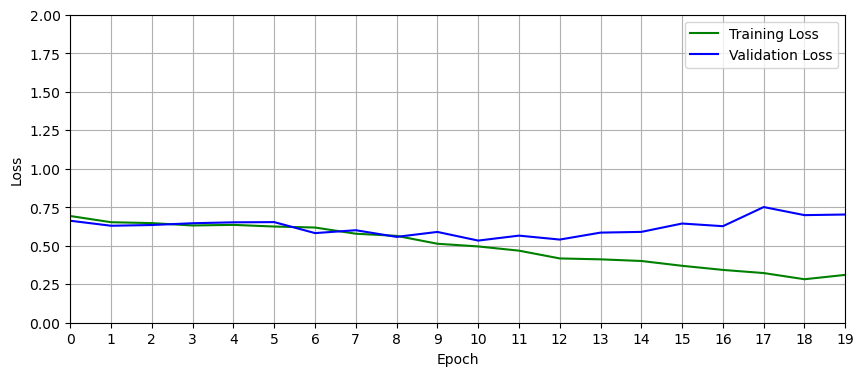

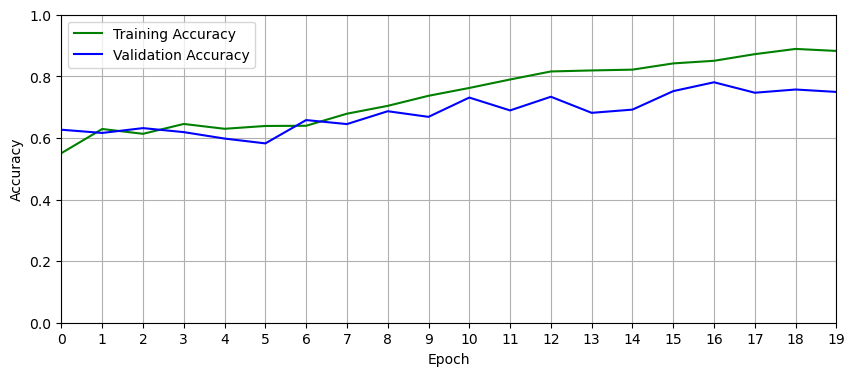

In [11]:
# Retrieve training results
train_loss = char_cnn_lstm_history.history["loss"]
train_acc  = char_cnn_lstm_history.history["accuracy"]
valid_loss = char_cnn_lstm_history.history["val_loss"]
valid_acc  = char_cnn_lstm_history.history["val_accuracy"]
   
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 2.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);
 
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [13]:
test_loss, test_acc = char_cnn_lstm_model.evaluate(X_test_tensor, y_test)
print(f"Test accuracy: {test_acc*100:.3f}")

y_pred = char_cnn_lstm_model.predict(X_test_tensor)
f1 = f1_score(y_test, y_pred.round())
print(f'F1 Score: {f1}')

15/15 [==============================] - 0s 6ms/step - loss: 0.7203 - accuracy: 0.7280
Test accuracy: 72.803


AttributeError: 'History' object has no attribute 'predict'

In [ ]:
# Compile the model
char_cnn_lstm_model.compile(loss='binary_crossentropy',  optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# Print the model summary
char_cnn_lstm_model.summary()